<a href="https://colab.research.google.com/github/nTrouvain/TD1-Timeseries-Analysis/blob/main/TD1_Timeseries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD1: Timeseries analysis using autoregressive methods and general Box-Jenkins methods

Some useful translations, just in case:

- **a timeseries**: une série temporelle (always plural in English)
- **a trend**: une tendance
- **a lag**: un retard, un décalage dans le temps
- **stationary**: stationnaire


Some interesting content to dive deeper and/or go further about timeseries analysis, or that might help you during the TD:

- [The engineering statistics handbook on timeseries analysis](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm)

- [A Stanford class on autoregressive models seen as generative models](https://deepgenerativemodels.github.io/notes/) (and more on deep generative models)

In [5]:
!pip install statsmodels==0.12.1
!pip install sktime

  Using cached sktime-0.8.1.tar.gz (11.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for sktime
Failed to build sktime
    Running setup.py install for sktime: started
    Running setup.py install for sktime: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Python\Python39\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Ordi\\AppData\\Local\\Temp\\pip-install-h48t7fn3\\sktime_c268772e8203423686362e885b39d443\\setup.py'"'"'; __file__='"'"'C:\\Users\\Ordi\\AppData\\Local\\Temp\\pip-install-h48t7fn3\\sktime_c268772e8203423686362e885b39d443\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Ordi\AppData\Local\Temp\pip-wheel-2io1r1hh'
       cwd: C:\Users\Ordi\AppData\Local\Temp\pip-install-h48t7fn3\sktime_c268772e8203423686362e885b39d443\
  Complete output (1322 lines):
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  C:\Program Files (x86)\Microsof

In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import sktime
import scipy


  copying sktime\performance_metrics\tests\test_performance_metrics_forecasting.py -> build\lib.win-amd64-3.9\sktime\performance_metrics\tests
  copying sktime\performance_metrics\tests\_config.py -> build\lib.win-amd64-3.9\sktime\performance_metrics\tests
  copying sktime\performance_metrics\tests\__init__.py -> build\lib.win-amd64-3.9\sktime\performance_metrics\tests
  creating build\lib.win-amd64-3.9\sktime\regression\all
  copying sktime\regression\all\__init__.py -> build\lib.win-amd64-3.9\sktime\regression\all
  creating build\lib.win-amd64-3.9\sktime\regression\compose
  copying sktime\regression\compose\_ensemble.py -> build\lib.win-amd64-3.9\sktime\regression\compose
  copying sktime\regression\compose\__init__.py -> build\lib.win-amd64-3.9\sktime\regression\compose
  creating build\lib.win-amd64-3.9\sktime\regression\interval_based
  copying sktime\regression\interval_based\_tsf.py -> build\lib.win-amd64-3.9\sktime\regression\interval_based
  copying sktime\regression\interv

## 1. Analysis

For this exercise, we will use a timeseries representing daily average temperature in Melbourne, Australia between 1980 and 1990.

This timeseries will be stored in a [Pandas DataFrame object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), a standard to handle tabular data in Python.

This analysis will follow the steps proposed by George Box and Gwilym Jenkins in 1970, called [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method), which emphasizes issues encountered when appliying autoregressive methods.

In [7]:
# Read data from remote repository
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv", index_col=0)

In [8]:
# Display the 5 first data points
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


### 1.1 Run-plots analysis

"Run-plots" are the simplest representation of a timeseries, where the x-axis represents time and the y-axis represents the observed variable, here temperature in Celsius degrees.


**Question: Given the figures and the statistic test below, what hypothesis can you draw regarding the behaviour of this timeseries? Is is stationary? Does it displays seasonality? Trending? Explain. You can create additional figures if you need.**

The timeseries seems to be quite stationary because the result of the test result return a p-value << 0.5, so the non stationary hypothesis is rejected (so it's probably stationary). Moreover, the trend of the curve is like a sinus curve (with a period of one year). 

<AxesSubplot:title={'center':'Temperature in Melbourne - 1980 to 1990'}, xlabel='Date'>

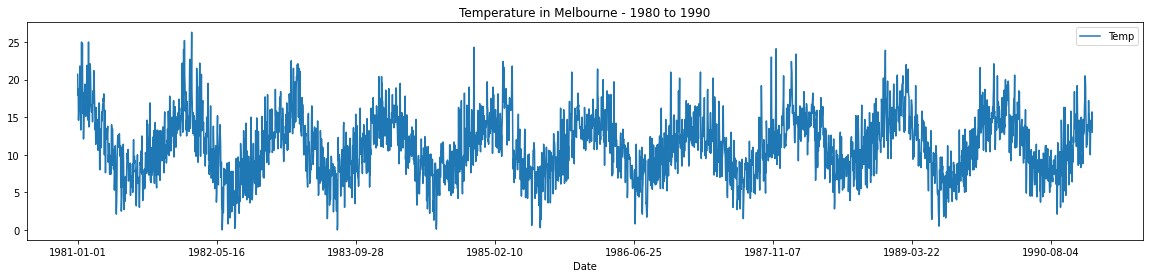

In [9]:
# Plot the full timeseries
df.plot(figsize=(20, 4), title="Temperature in Melbourne - 1980 to 1990")

<AxesSubplot:title={'center':'Temperature in Melbourne - one year'}, xlabel='Date'>

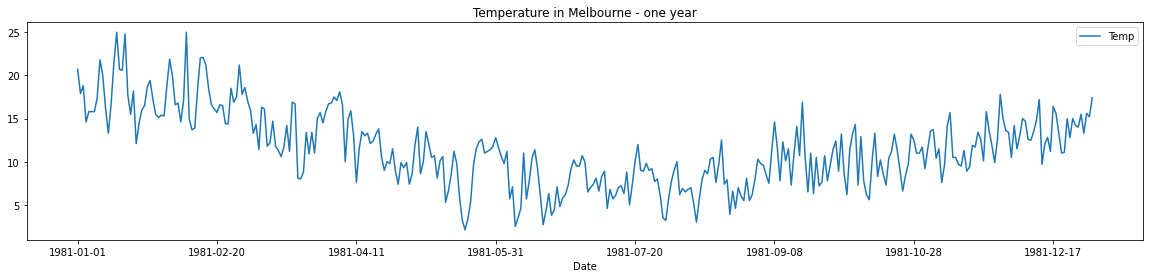

In [10]:
# Plot the first year of data
df.iloc[:365].plot(figsize=(20, 4), title="Temperature in Melbourne - one year")

The Augmented Dickey-Fuller test is a statistical test used to check
the stationarity of a timeseries. It is implemented in the `adfuller()` function in `statsmodels`.

In [11]:
from statsmodels.tsa.stattools import adfuller

adf, p, *other_stuff = adfuller(df)

print(f"p-value (95% confidence interval): {p:g}, statistics: {adf:g}")

p-value (95% confidence interval): 0.000247083, statistics: -4.4448


### 1.2 Autocorrelation and partial autocorrelation

Autocorrelation (and partial autocorrelation) are metrics that can be computed to evaluate **how dependent the variable is from its $n$ previous values**, what is called a **lag (of length n)**.

**Question: Plot $X[t-1]$ versus $X[t]$, for all $t$. What can you conclude on the autocorrelation of the series with a lag of 1? You can also compute the Pearson correlation coefficient between $X[t-1]$ and $X[t]$.**

*Some help:*

- You can create a new DataFrame with all values shifted from $n$ timestep using the `.shift()` method of the DataFrame. See Pandas documentation for more.

- You can plot some data versius some other using the `plt.scatter(X, Y)` method of Matplotlib. This plots a dot on the figure for every couple `(x, y)`
in `X` and `Y`. See Matplotlib documentation for more.

- Pearson coefficient can be computed using the DataFrame `.corr()` method. This method computes the correlation coefficient between all variables (*columns*) in the DataFrame. Try appliying this method to a DataFrame where one column is $X[t]$ and another column is the shifted timeseries $X[t-1]$. Note that you can merge two DataFrames into one using the function `pd.concat(dataframes)` of Pandas. See Pandas documentation for more.

In [12]:
# Create a shifted version of the timeseries:
df_shifted = df.shift(periods=1)


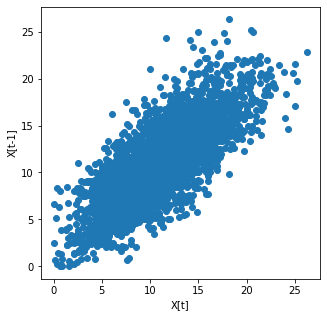

In [13]:
# Plot df vs. df_shifted
plt.figure(figsize=(5, 5))
plt.scatter(df, df_shifted)

plt.xlabel("X[t]")
plt.ylabel("X[t-1]")
plt.show()

It seems to be like X[t] timeseries explains globaly the X[t-1] timeseries because the graph above is quite like a linear graph. But in middle of the graph, the line is very thick so it's difficult to explain the X[t-1] by the X[t] value. ~ not high correlated 

**Pearson correlation coefficient**

To compute this coefficient, we first need to ensure that our variable follows a normal distribution. Let's plot the distribution, using the `.hist()` method of DataFrame objects:

*(Optional)* Perform a normality test, using `scipy.stats.normaltest`.

array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

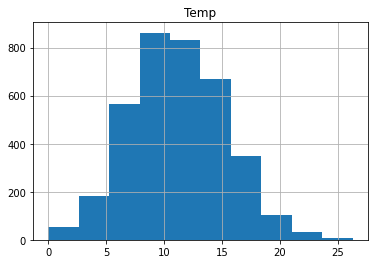

In [14]:
# Plot of the distribution of the variable
# (in our case, the temperature histogram)

df.hist()
# The hist graph seems to be an normal dist hist with a ~ mean of 12

In [15]:
from scipy import stats

# Normality test
k2, p = scipy.stats.normaltest(df)

print(f"p-value (95% confidence interval): {p[0]:g}, statistics: {k2[0]:g}")
# The result results with a p-value of 0.00009 << 0.05 so we can reject the null hypothesis of non normal distribution


p-value (95% confidence interval): 9.89899e-05, statistics: 18.441


In [16]:
# (Optional) Compute Pearson coefficients
 
# First, concatenate df and df_shifted in df_all, following axis 1
# (concatenate columns, not rows !)
df_all = pd.concat([df, df_shifted[1:]], axis=1)

# Rename the columns
df_all.columns = ["X[t]", "X[t-1]"]
df_all.head()

# Compute correlation and print it
df_all.corr()
# The cor between X[t] and X[t-1] is 0.77, this is very closer to 1 than 0 so we can suggest that there is a link between those two vars

,X[t],X[t-1]
X[t],1.00000,0.77487
X[t-1],0.77487,1.00000


We can see that the value has a quite normal distribution so we can calculate the Pearson Correlation Value. The correlation between X[t-1] and X[t] is 0.77 (~ close to 1) so the two var are very correlated. We probably explain X[t] by X[t-1].

---
We will now compute autocorrelation function (ACF) and partial autocorrelation function (PACF) of the timeseries. These functions compute correlation (or partial correlation) between $X[t]$ and $X[t-n]$, for an interval of different lags $n$. For now, we only evaluated correlation for lag $n=1$.

**Question: Plot the ACF and the PACF of the timeseries, with $n={1, \dots, 31}$ (one month lag) and $n={1, \dots, 730}$ (2 years lag). What is your hypothesis on the lag to use to create the model ?**


*Some help:*

- See documentation of `statsmodels.graphics.tsaplots.plot_acf` to understand how to change the number of lags to plot.

- **Autocorrelation** is the result of the multiplication (or convolution) of all points of the signal with themselves, shifted in time by a lag of $n$. The **autocorrelation function** (ACF) is the function giving autocorrelation for any lag $n$.

- **Partial autocorrelation** is similar to autocorrelation, but the correlation between two points of the signal is computed assuming that this two points are independent from all points between them in time.  The **partial autocorrelation function** (PACF) is the function giving partial autocorrelation for any lag $n$.

- Autocorrelation is helpful to check if a process in autoregressive. **Autoregressive processes are auto-correlated**.

- Partial autocorrelation is helpful to find the order of an autoregressive process, i.e. **how many past steps are needed to predict the future one**.

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#### 1.2.1 Autocorrelation

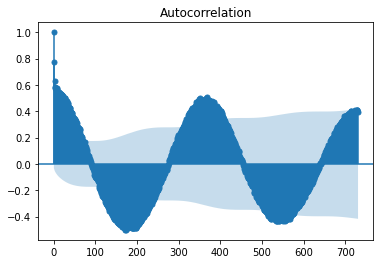

In [18]:
# Plot autocorrelation for lags between 1 and 730 days
plot_acf(df.values.squeeze(), lags=730)
plt.show()

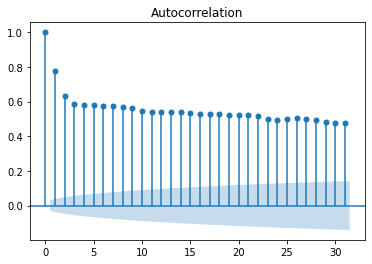

In [19]:
# Plot autocorrelation for lags between 1 and 31 days
plot_acf(df.values.squeeze(), lags=31)
plt.show()

#### 1.2.2 Partial autocorrelation

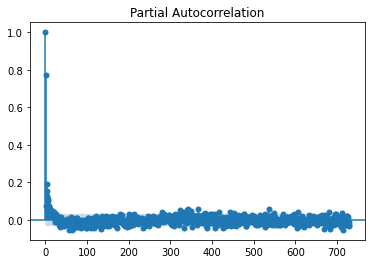

In [20]:
# Plot partial autocorrelation for lags between 1 and 730 days
plot_pacf(df.values.squeeze(), lags=730)
plt.show()

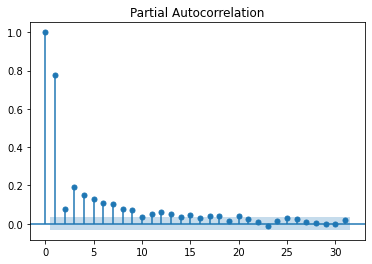

In [21]:
# Plot partial autocorrelation for lags between 1 and 31 days
plot_pacf(df.values, lags=31)
plt.show()

The correlation seem to be the strongest with a lag which is a multiple of 180.2 (1/2 year), but verry bad monthly or with any other lag.

## 2. Modeling

### 2.0 Modeling: AR from scratch (just as an example, nothing to do here)

AR stands for AutoRegressive. Autoregressive models describe the value of any points in a timeseries given the values of $p$ previous points, establishing a linear relashionship between them such that:

$$
X_t = \alpha + \beta_1 X_{t-1} + \beta_2 X_{t-2} + ... + \beta_{p} X_{t-p} + \epsilon_t
$$

where $X$ is a timeseries, $p$ is the lag used in the AR model, also called the **order** of the model, and $\beta=\{\beta, \dots, \beta_p\}$ and $\alpha$ are the parameters we want to estimate. $\epsilon_t$ is a white noise random process that we will consider to be 0 for all time steps in our model.

$X_t$ is therefore linearly dependent from its $p$ previous values $X_{t-1}, \dots, X_{t-p}$. We can learn $\beta_{[1, p]}$ and $\alpha$ using a linear regression defined by:

$$
[\alpha, \beta_{[1, p]}] = X \cdot X_{lags}^\intercal \cdot (X_{lags} \cdot X_{lags}^\intercal)^{-1}
$$

where $X$ is the whole timeseries with an available lag ($t-p$ timesteps have $p$ past values, the $p$ first timesteps do not have pasts values), and $X_{lags}$ are the $X_{t-1}, \dots, X_{t-p}$ for all time steps with an available lag $t-p$.

In [80]:
# We store all values of the series in a numpy array called series
series = df["Temp"].values

In [81]:
def auto_regression(series, order):
    
    n_points = len(series)

    # All lagged values will be stored in y_lag.
    # If order is 7, for each timestep we will store 7 values.
    X_lag = np.zeros((order, n_points-order))

    # All current values will be stores in X.
    X = np.zeros((1, n_points-order))
    for i in range(0, n_points-order-1):
        X_lag[:, i] = series[i:i+order]  # get the lagged values
        X[:, i] = series[i+order+1]  # get the current value

    # Add a constant term (c=1) to X_lag to compute alpha in the linear
    # regression
    X_lag = np.vstack((np.ones((1, n_points-order)), X_lag))

    # Linear regression
    coef = np.dot(np.dot(X, X_lag.T), scipy.linalg.pinv(np.dot(X_lag, X_lag.T)))
    
    alpha = coef[:, 0]
    beta = coef[:, 1:]

    return alpha, beta

In [95]:
alpha, beta = auto_regression(series, order=3)

Now that we have our coefficients learned, we can make predictions.

In [96]:
lag = beta.shape[1]

Y_truth = []  # real timeseries
Y_pred = []   # predictions
for i in range(0, len(series)-lag-1):
    # apply the equation of AR using the coefficients at each time steps
    y = alpha + np.dot(beta, series[i:i+lag]) # y[t] = alpha + y[t-1]*beta1 + y[t-2]*beta2 + ...

    Y_pred.append(y)
    Y_truth.append(series[i+lag+1])

Y_pred = np.array(Y_pred).flatten()
Y_truth = np.array(Y_truth).flatten()

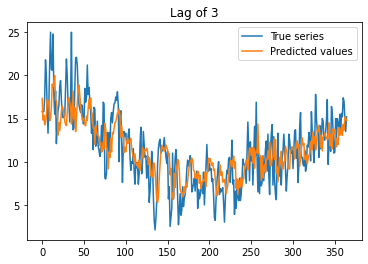

In [98]:
# Plot the results for one year
plt.plot(series[lag+1:lag+366], label="True series")
plt.plot(Y_pred[:365], label="Predicted values")
plt.title(f'Lag of {lag}')
plt.legend()
plt.show()

And here are our coefficients:

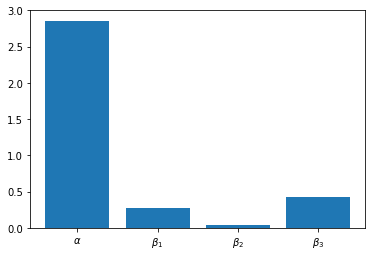

In [99]:
coefs = np.c_[alpha, beta]
plt.bar(np.arange(coefs.shape[1]), coefs.flatten())
labels = ['$\\alpha$']
for i in range(beta.shape[1]):
    labels.append(f"$\\beta_{i+1}$")

plt.xticks(np.arange(coefs.shape[1]), labels)
plt.show()

### 2.1 Modeling : ARIMA


In [100]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average, capturing the key aspects of the model :

- **AR** : *AutoRegressive* A model that uses the dependent relationship between an observation and some number of lagged observations.
A pure AR model is such that :
$$
Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + ... + \beta_{p} Y_{t-p} + \epsilon_1
$$
- **I** : *Integrated* The use of differencing of raw observations in order to make the time series stationary
- **MA** : *Moving Average* A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations
A pure moving average model is such that :
$$
Y_t = \alpha + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_q \epsilon_{t-q}
$$


Thus finally, the equation for ARIMA becomes :
$$
Y_t = \alpha + \beta_1 Y_{t-1} + ... + \beta_p Y_{t-p} \epsilon_t + \phi_1 \epsilon_{t-1} + ... + \phi_q \epsilon_{t-q} 
$$

Each of these components is specified in the model as a parameter :
- **p** : number of lag observations
- **d** : number of times that raw observations are differenced. 
It is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d= 0
- **q** : size of moving average window

Now, we will fit an ARIMA forecast model to the daily minimum temperature data.
The data contains a one-year seasonal component :


In [73]:
# seasonal difference
differenced = df.diff(365) 
# trim off the first year of empty data
differenced = differenced[365:]

In [117]:
# Create an ARIMA model (check the statsmodels docs) (p,d,q)
# d = 0 because the serie is stationary (see before)
model = ARIMA(series, order=(3, 0, 15))

# fit model
model_fit = model.fit()
print(model_fit.summary())

C:\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

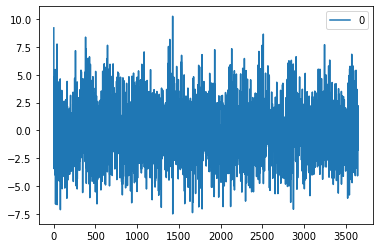

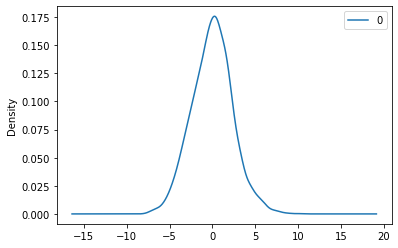

Residuals stats:                  0
count  3650.000000
mean     -0.019084
std       2.397660
min      -7.495908
25%      -1.617907
50%       0.036084
75%       1.510988
max      10.244028


In [ ]:
# reviewing the residual errors
# line plot
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot
residuals.plot(kind='kde')
plt.show()
# summary stats
print("Residuals stats:", residuals.describe())

To evaluate the ARIMA model, we will use walk forward validation. First we split the data into a training and testing set (initially, a year is a good interval to test for this dataset given the seasonal nature). 
A model will be constructed on the historic data and predict the next time step. The real observation of the time step will be added to the history, a new model constructed and the next time step predicted. 
The forecasts will be collected together to the final observations to give an error score (for example, RSME : root mean square error)

RSME :  3.0962731961259613


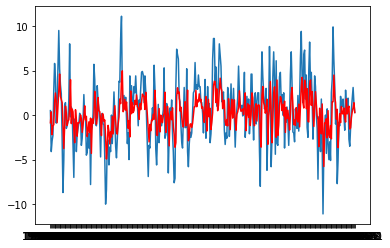

In [109]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# rolling forecast with ARIMA

train, test = differenced.iloc[:-365], differenced.iloc[-365:]

# walk-forward validation
values = train.values
history = [v for v in values]
predictions = list()
test_values = test.values
for t in range(len(test_values)):
  # fit model
  model = ARIMA(history, order=(7,0,0))
  model_fit = model.fit()
  # make prediction 
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  history.append(test_values[t])

# evaluate forecast
rsme = sqrt(mean_squared_error(test_values, predictions))
print('RSME : ', rsme)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

We can also use the predict() function on the results object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset. 

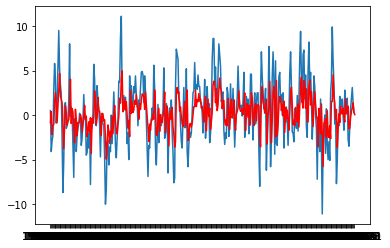

In [110]:
forecast = model_fit.predict(start=len(train.values), end=len(differenced.values), typ='levels')
plt.plot(test)
plt.plot(forecast, color='red')
plt.show()

## Exercise: Mauna Loa CO<sub>2</sub> concentration levels (1975 - 2021)


Carbon dioxyde (CO<sub>2</sub>) is a gas naturaly present in our environment. However, the concentration of CO<sub>2</sub> is increasing every year, mainly because of human activities. It is one of the major cause of global warming, and its value is precautiounously measured since 1973 at the Mauna Loa observatory, in Hawaii.

We will get interested on the measures performed between 1975 and 2021. The dataset is composed of monthly averaged values. Values are expressed in *ppm* (parts-per-million).

**Question: Appliying the method described above, model the behaviour of this timeseries.**

**Question: Using your model, make predictions from 2001 to 2021, and evaluate the performance of your model. Make some projections about the evolution of the concentration after 2021.**

**Do not forget to explain your hypotheses, choices and results.**

*Some help*

- Be careful ! This timeseries is more difficult to model (do not forget the stationarity property...)
- If a timeseries is not stationary, one can **differenciate** its values over time to create a stationary approximation of the timeseries (like ARIMA does). You can also **remove the linear trend** from the data. Differencing (for an order 1 differenciation) implies transforming $X[t]$ into $X[t] - X[t-1]$.
- Maybe a seasonal model (SARIMA, ...) could be interesting ?
- You can do projections by using the model as a **generative model**: using the predicted value $X[t]$, you can predict $X[t+1$] using $X[t]$, then predict $X[t+2]$ using $X[t+1]$ and so on, using only the predictions of your model. For instance, with a dataset stopping in December 2021, you can predict January 2022 using December 2021, which you know from the dataset. Then, you can predict February 2022 from January 2022, March 2022 from February 2022...

*Reference:*

K.W. Thoning, A.M. Crotwell, and J.W. Mund (2021), Atmospheric Carbon Dioxide Dry Air Mole Fractions from continuous measurements at Mauna Loa, Hawaii, Barrow, Alaska, American Samoa and South Pole. 1973-2020, Version 2021-08-09 National Oceanic and Atmospheric Administration (NOAA), Global Monitoring Laboratory (GML), Boulder, Colorado, USA

In [118]:
ts = pd.read_csv("https://gml.noaa.gov/aftp/data/trace_gases/co2/in-situ/surface/mlo/co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt",
                 header=150, sep=" ")

ts = ts[ts["year"] > 1975]

time_index = pd.DatetimeIndex(pd.to_datetime(ts[["year", "month", "day"]]))
ts = ts.set_index(time_index)
ts = pd.Series(ts["value"])

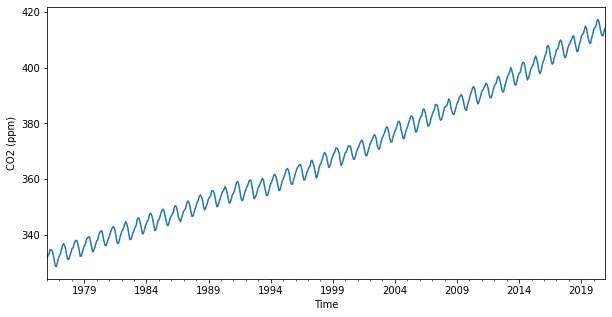

In [120]:
ts.plot(figsize=(10, 5))

plt.xlabel("Time")
plt.ylabel("CO2 (ppm)")
plt.show()

<AxesSubplot:title={'center':'CO2 (ppm) in one year'}>

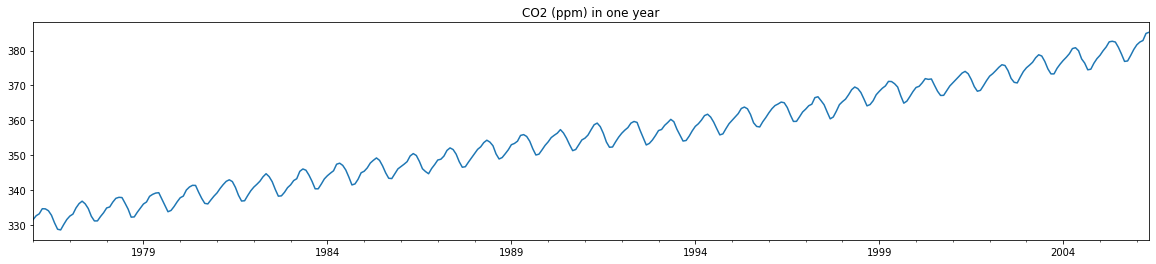

In [121]:
# Plot the first year of data
ts.iloc[:365].plot(figsize=(20, 4), title="CO2 (ppm) in one year")

In [122]:
from statsmodels.tsa.stattools import adfuller

# The curve of the values seems to increase over years so it might not be stationary
adf, p, *other_stuff = adfuller(ts)

print(f"p-value (95% confidence interval): {p:g}, statistics: {adf:g}")
# p-value 1 >> 0.05 so we can't reject the hypothesis of non stationiary  (Ok !)

p-value (95% confidence interval): 1, statistics: 3.50104


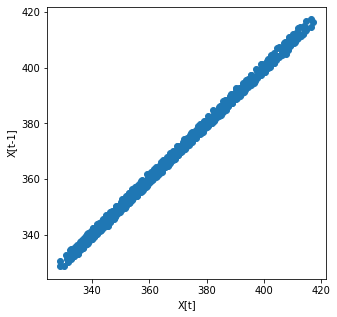

In [123]:
# Create a shifted version of the timeseries:
ts_shifted = ts.shift(periods=1)
plt.figure(figsize=(5, 5))
plt.scatter(ts, ts_shifted)

plt.xlabel("X[t]")
plt.ylabel("X[t-1]")
plt.show()

# It seems that X[t] explain perfectly X[t-1]

<AxesSubplot:>

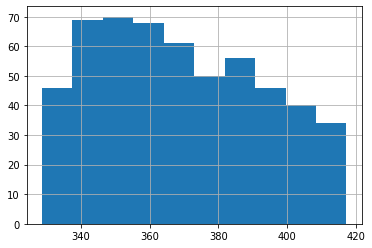

In [127]:
ts.hist()

In [130]:
from scipy import stats
# It not seems to be normaly distribuated
k2, p = scipy.stats.normaltest(ts)

print(f"p-value (95% confidence interval): {p:g}, statistics: {k2:g}")

# p-value is 5e-36 << 0.5  so we can reject the null hypothesis of non normal distribution

p-value (95% confidence interval): 5.4641e-36, statistics: 162.39


***(Your code and explanations here and below)***